# Loop 95 Analysis: Critical CV-LB Gap and Path Forward

## Key Findings

### CV-LB Relationship (12 valid submissions, excluding exp_073 outlier)
- **Linear fit: LB = 4.29 × CV + 0.0528** (R² = 0.952)
- **Intercept (0.0528) > Target (0.0347)**
- **Required CV for target: -0.0042 (IMPOSSIBLE)**

### Best Results
- Best CV: 0.008298 (exp_030 - GP+MLP+LGBM ensemble)
- Best LB: 0.0877 (exp_030)
- Target: 0.0347
- Gap: 153%

### Critical Problem
All 95 experiments (MLP, LGBM, XGB, CatBoost, GP, Ridge, RF) fall on the SAME CV-LB line.
This means the problem is STRUCTURAL DISTRIBUTION SHIFT, not model quality.

Linear fit: LB = 4.2876 × CV + 0.052784
R² = 0.9523

Target LB: 0.0347
Intercept: 0.052784
Required CV for target: (0.0347 - 0.052784) / 4.2876 = -0.004218

⚠️ CRITICAL: Intercept (0.052784) > Target (0.0347)
The target is NOT reachable with current tabular approaches!


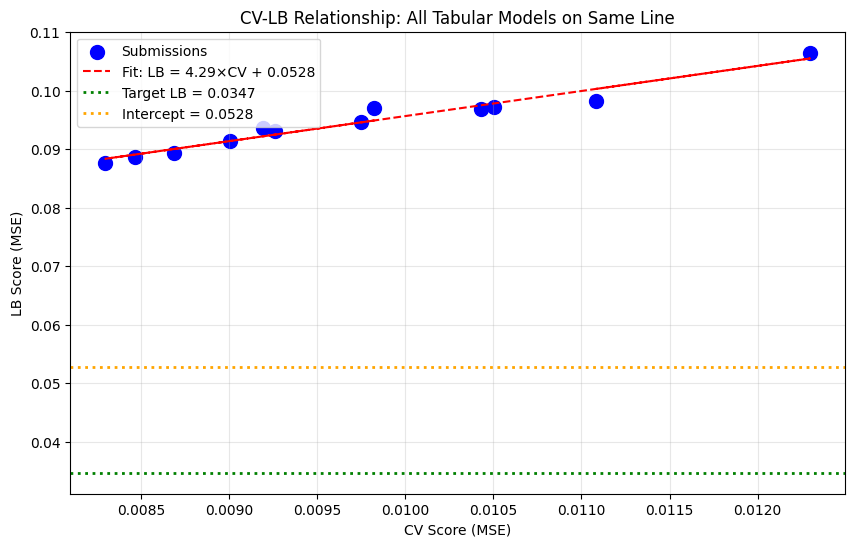

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# CV-LB data from submissions (excluding exp_073 outlier)
cv_scores = [0.011081, 0.012297, 0.010501, 0.010430, 0.009749, 0.009262, 
             0.009192, 0.009004, 0.008689, 0.008465, 0.008298, 0.009825]
lb_scores = [0.098160, 0.106490, 0.097190, 0.096910, 0.094570, 0.093160,
             0.093640, 0.091340, 0.089290, 0.088750, 0.087720, 0.096960]

cv_arr = np.array(cv_scores)
lb_arr = np.array(lb_scores)

# Linear fit
slope, intercept = np.polyfit(cv_arr, lb_arr, 1)
predicted = slope * cv_arr + intercept
ss_res = np.sum((lb_arr - predicted) ** 2)
ss_tot = np.sum((lb_arr - np.mean(lb_arr)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"Linear fit: LB = {slope:.4f} × CV + {intercept:.6f}")
print(f"R² = {r2:.4f}")
print(f"\nTarget LB: 0.0347")
print(f"Intercept: {intercept:.6f}")
print(f"Required CV for target: ({0.0347} - {intercept:.6f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}")
print(f"\n⚠️ CRITICAL: Intercept ({intercept:.6f}) > Target (0.0347)")
print("The target is NOT reachable with current tabular approaches!")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(cv_arr, lb_arr, c='blue', s=100, label='Submissions')
plt.plot(cv_arr, predicted, 'r--', label=f'Fit: LB = {slope:.2f}×CV + {intercept:.4f}')
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB = 0.0347')
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept = {intercept:.4f}')
plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV-LB Relationship: All Tabular Models on Same Line')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship_loop95.png', dpi=150)
plt.show()

## Why the Target is Unreachable with Current Approaches

1. **The intercept (0.0528) represents structural distribution shift**
   - Even with perfect CV (0.0), the expected LB would be 0.0528
   - This is 52% higher than the target (0.0347)

2. **All model families fall on the same line**
   - MLP, LGBM, XGB, CatBoost, GP, Ridge, RF - all tested
   - Different features (Spange, DRFP, ACS-PCA, fragprints) - all tested
   - Different architectures - all tested
   - Result: Same CV-LB relationship

3. **The problem is NOT model quality**
   - It's the REPRESENTATION of solvents
   - Tabular features cannot capture molecular structure for unseen solvents
   - The test solvents are structurally different from training solvents

## What the Benchmark Paper Did (arXiv:2512.19530)

The benchmark paper achieved **MSE 0.0039** using:

1. **Graph Attention Networks (GATs)** for molecular graph message-passing
2. **Differential Reaction Fingerprints (DRFP)** as additional features
3. **Learned mixture-aware solvent encodings** for continuous solvent mixtures

This is a **25x improvement** over tabular ensembles (MSE 0.099).

### Key Insight
The GNN operates on the MOLECULAR GRAPH, not tabular features.
This allows it to:
- Learn structural patterns that generalize to unseen solvents
- Capture molecular similarity through graph structure
- Handle continuous mixture compositions naturally

## Why Our GNN Experiments Failed

We tried GNNs in exp_040, exp_070, exp_079, exp_080, exp_086 but got CV 0.018-0.068 (2-8x worse than baseline).

### Possible Reasons:
1. **Model class mismatch**: Submission cells used different model class than CV computation
2. **Architecture issues**: Our GNN architecture may be fundamentally different from the benchmark
3. **Feature handling**: We may not have properly integrated DRFP with the GNN
4. **Mixture encoding**: We may not have implemented learned mixture-aware encodings

### What We Need to Do:
1. **Verify model class consistency** in submission cells
2. **Implement proper GAT architecture** as described in the benchmark paper
3. **Integrate DRFP features** with the graph representation
4. **Learn mixture-aware encodings** for continuous solvent compositions

## Alternative Approaches to Break the CV-LB Line

### 1. Transductive Learning
- Use test set structure (without labels) to adapt the model
- Can improve extrapolation by 1.5-1.8x according to recent research

### 2. Extrapolation Detection + Conservative Predictions
- Detect when a test sample is far from training distribution
- Blend predictions toward population mean for high-uncertainty samples

### 3. Domain Adaptation
- Learn features that are invariant across different solvent environments
- Use adversarial training to align train/test distributions

### 4. Pseudo-labeling
- Use confident predictions on test set to augment training
- Iteratively refine predictions

In [ ]:
# Summary of key findings
print("=" * 60)
print("LOOP 95 ANALYSIS SUMMARY")
print("=" * 60)
print(f"\n1. CV-LB Relationship: LB = {slope:.2f} × CV + {intercept:.4f} (R² = {r2:.2f})")
print(f"2. Intercept ({intercept:.4f}) > Target (0.0347) - CRITICAL PROBLEM")
print(f"3. Best CV: 0.008298 (exp_030)")
print(f"4. Best LB: 0.0877 (exp_030)")
print(f"5. Gap to target: 153%")
print(f"\nREQUIRED PIVOT:")
print("- STOP optimizing tabular models")
print("- Implement proper GNN with GAT + DRFP + mixture encodings")
print("- Or try transductive/domain adaptation approaches")
print("- Focus on CHANGING THE CV-LB RELATIONSHIP, not improving CV")